In [372]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt



In [373]:
student_id = 31105327 # Add in your student ID
student_name = 'Omar Afifi' # Add in your student name

# Task 1: Draw test points on the left image

In [481]:
# Write your code here
left_img = cv2.imread("left.jpg",cv2.IMREAD_GRAYSCALE)



In [482]:
pts = np.array([[337,196,1], [467,289,1], [252,169,1], [262,255,1], [241,135,1]])


In [483]:
def remove_scale(pts):
    pts[:, 0] = pts[:, 0]/pts[:, 2]
    pts[:, 1] = pts[:, 1]/pts[:, 2]
    
    return np.delete(pts,2,1)


In [484]:
d2_coords = remove_scale(pts)

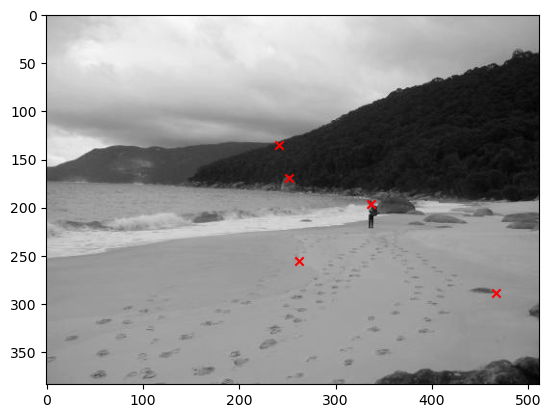

In [485]:
# Show results here
plt.imshow(left_img,'gray')
plt.scatter(d2_coords[:,0],d2_coords[:,1],marker="x",color="r")

# Task 2: Use Homography to find right image points


In [379]:
# Write your code here
H = np.array([[1.6010, -0.0300, -317.9341],
               [0.1279, 1.5325 , -22.5847],
               [0.0007,    0   ,   1.2865 ]])


In [380]:
right_pts = np.matmul(H,pts.T).T
d2_coords_right= remove_scale(right_pts)

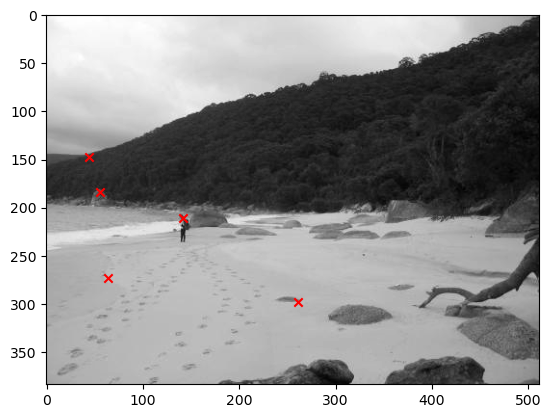

In [382]:
# Show results here
right_img = cv2.imread("right.jpg",cv2.IMREAD_GRAYSCALE)
plt.imshow(right_img,'gray')
plt.scatter(d2_coords_right[:,0],d2_coords_right[:,1],marker="x",color="r")

#### Demonstrate your understanding by answering the question below:
#### Describe the process of calculating a homography matrix. Ensure you list out the key steps

#### -First we find the ket points or features (corners) in both Images.
#### -After that we create descirptors for each of these features, that are ideally invariant to rotations and translations.
#### -The we run a feature mathcing algorithm, such as a k-d tree or FAANG to match the features between the two images.
#### -Then we calculate the Homography matrix using an alogirthm such a RANSAC, where it selects 4 matches at random and solves for the homography matrix, then applies the calculated homography matrix to all the other matches and calculates the error. It keeps doing that, while only keeping the homography matrix with the least error, until a certain error has been achieved, or for a certain number of times.

# Task 3: Bilinear interpolation of the right image

In [383]:
def bilinear_interpolation(img,coords):
    if (len(coords.shape)>1):
        x,y = coords[:,0],coords[:,1]
    else:
        x,y = coords[0],coords[1]
    x0, y0 = np.floor(x).astype(int), np.floor(y).astype(int)
    x1, y1 = np.ceil(x).astype(int), np.ceil(y).astype(int)

    # Ensure points are within image bounds, however this should never happen if input coords are valid
    x0 = np.clip(x0, 0, img.shape[1] - 1)
    x1 = np.clip(x1, 0, img.shape[1] - 1)
    y0 = np.clip(y0, 0, img.shape[0] - 1)
    y1 = np.clip(y1, 0, img.shape[0] - 1)

    # Distances
    dx = x - x0
    dy = y - y0

    intensities = (1-dy)*((1-dx) * img[y0, x0] + dx*img[y0, x1])+(dy)*((1-dx) * img[y1, x0] + dx*img[y1, x1])
    return intensities

In [384]:
# Show results here
bilinear_interpolation(right_img,d2_coords_right)


array([ 67.98285943, 144.89440932, 100.12844064, 186.77266219,
        58.53918366])

#### Demonstrate your understanding by answering the question below:
#### Why is bilinear interpolation necessary? Which equation did you use to calculate the bilinear interpolation and why?

#### After applying the homography matrix, the resulting coordinates are not integers, therefore the calculated coordinates lie somewhere betweeen pixels on the right image, rather than a single pixel. Rounding the cooridnate value to the nearest integer could still work, but it would result in poor mathces, and later on when we are stiching the image, might result in lower image quality
#### I used the weighted mean method, since it is the most relevant in our case and the easiest to implement

# Task 4: Image stitching

In [479]:
def stitch_two_imgs(l_img,r_img,Homography):
    h, w= l_img.shape
    wide_img = np.zeros((h,w*2))
    wide_img[:,0:w] = l_img
    wide_img_coords = np.ones([h,3]).astype(int)
    wide_img_coords[:,1] = np.arange(h)
    for col in range(w):
        wide_img_coords[:,0] = col + w
        right_img_coord = np.matmul(Homography,wide_img_coords.T).T
        right_img_coord= remove_scale(right_img_coord)
        val = bilinear_interpolation(r_img,right_img_coord)
        wide_img[wide_img_coords[:,1],wide_img_coords[:,0]] = (np.array(right_img_coord[:,0]>=0)&np.array(right_img_coord[:,0]<=w)&np.array(right_img_coord[:,1]>=0)&np.array(right_img_coord[:,1]<=h)) * val
    return wide_img

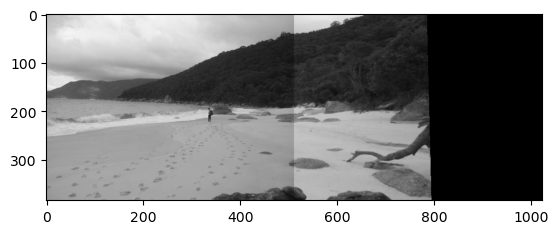

In [480]:
# Show results here
wide_img = stitch_two_imgs(left_img,right_img,H)
plt.imshow(wide_img,'gray')

#### Demonstrate your understanding by answering the question below:
#### Why are some pixels invalid after applying the homography matrix

#### Most pixels in the right most quarter are invalid, that is because there is an overlap between images 1 and 2, which results on the final image not having double the width.
#### And generally speaking we can always expect that when image stitching due to the shifting of prespective between images, since we are trying to fit a cruved surface image into a flat plane, so the wider the stiteched image is, the more stretched it will appear on the sides.

# Task 5: Better blending

In [430]:
# Write your code here
cropped_img = wide_img
w = wide_img.shape[1]
for x in range(w):
    if (np.sum(wide_img[:,x]) == 0):
        wide_img = wide_img[:,0:x]
        break


In [431]:
# Using the features from earlier, we can find the scale of brightness between the left and right images
h, w= right_img.shape
left_feats = left_img[d2_coords[:,1],d2_coords[:,0]]
right_feats = bilinear_interpolation(right_img,d2_coords_right)
scale = np.mean(right_feats/left_feats)
wide_img[0:h,0:w] = wide_img[0:h,0:w]*scale
wide_img[0:h,w-5:w+5] = cv2.GaussianBlur(wide_img[0:h,w-5:w+5], (7,7), 0)


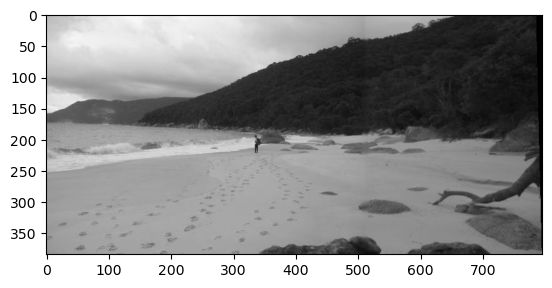

In [433]:
# Show results here
plt.imshow(wide_img,'gray')

#### Demonstrate your understanding by answering the question below:
#### Describe the steps you have used to improve the blending process. Why were they effective? 

#### firstly, by cutting the first row to the left where all pixels are zero, the right-most quarter was eliminated.
#### Secondly, by using the features given earlier, we can calculate the mean brightness of the features in both the left and right images, whcih would give us an idea of the scale of brightness between the two images. This scale can be then used to scale one half of the image, to match the other half. This workd because we know that the features should match, so if there is a mismatch in birghtness on the features, then we would expect the same mismatch to be between all the matches between the two images, so by scaling one of the images, we eleminate that mismatch.
#### Thirdly, by using a guassian filter, we smooth out the horizontal gradient at the vertical edge between the two images, similar to what we did in lab 1, which makes it a bit harder to pick up on the stitch line.


# Task 6: Now try your own!

Make sure to print the final homography that you use.

In [401]:
# Write your code here

#WORKSHOP CODE
im_1 = cv2.cvtColor(cv2.imread('left_img.jpg'), cv2.COLOR_BGR2GRAY)
im_2 = cv2.cvtColor(cv2.imread('right_img.jpg'), cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create()

# Find the keypoints and descriptors
kp1, des1 = orb.detectAndCompute(im_1,None)
kp2, des2 = orb.detectAndCompute(im_2,None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
X1 = np.vstack([kp1[match.queryIdx].pt for match in matches])
X2 = np.vstack([kp2[match.trainIdx].pt for match in matches])
Hcv, mask = cv2.findHomography(X1, X2, cv2.RANSAC, 5.0)
print(Hcv)

[[ 2.30068733e+00  1.11748396e-01 -4.39005010e+03]
 [ 1.74253603e-01  1.89849653e+00 -5.40546518e+02]
 [ 3.32426238e-04 -2.06346015e-05  1.00000000e+00]]


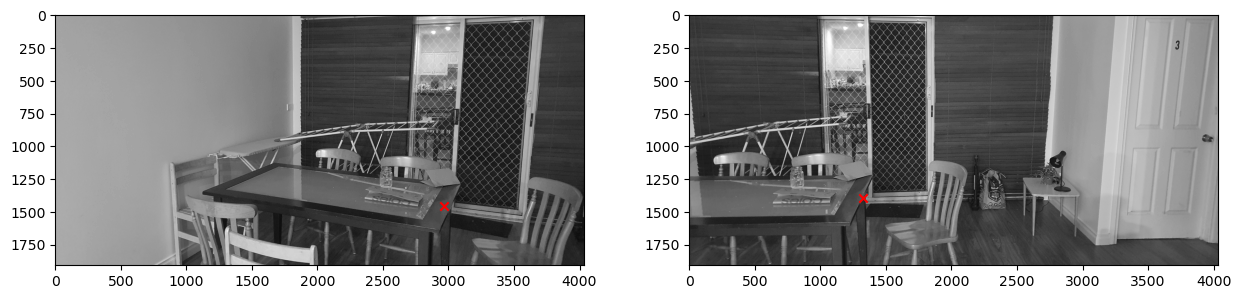

In [488]:
#Pick a random point to make sure Homography is valid
x = np.random.randint(im_1.shape[1])
y = np.random.randint(im_1.shape[0])
pt = np.array([x,y,1])
coord = np.matmul(Hcv,pt.T).T
coord = coord/coord[2]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im_1,'gray')
plt.scatter(x,y,marker="x",color="r")
plt.subplot(1,2,2)
plt.imshow(im_2,'gray')
plt.scatter(coord[0],coord[1],marker="x",color="r")

In [453]:
def scale_brightness(img1,img2,coords1,coords2):
    h, w= img1.shape
    #feats1 = img1[coords1[:,1],coords1[:,0]]
    feats1 = bilinear_interpolation(img1,coords1)
    feats2 = bilinear_interpolation(img2,coords2)
    #feats2 = img2[coords2[:,1],coords2[:,0]]
    scale = np.mean(feats1/feats2)
    scaled_img_2 = img2 * scale
    return scaled_img_2

In [477]:
h, w= im_1.shape
wider_img = stitch_two_imgs(im_1,im_2,Hcv)
scale = np.mean(wider_img[:,w-1])/np.mean(wider_img[:,w])
wider_img[:,w::] = wider_img[:,w::]*scale
wider_img[0:h,w-5:w+5] = cv2.GaussianBlur(wider_img[0:h,w-5:w+5], (7,7), 0)


In [489]:
mod_img_2 = scale_brightness(im_1,im_2,X1,X2)
SCALED_wider_img = stitch_two_imgs(im_1,mod_img_2,Hcv)
SCALED_wider_img[0:h,w-5:w+5] = cv2.GaussianBlur(SCALED_wider_img[0:h,w-5:w+5], (7,7), 0)

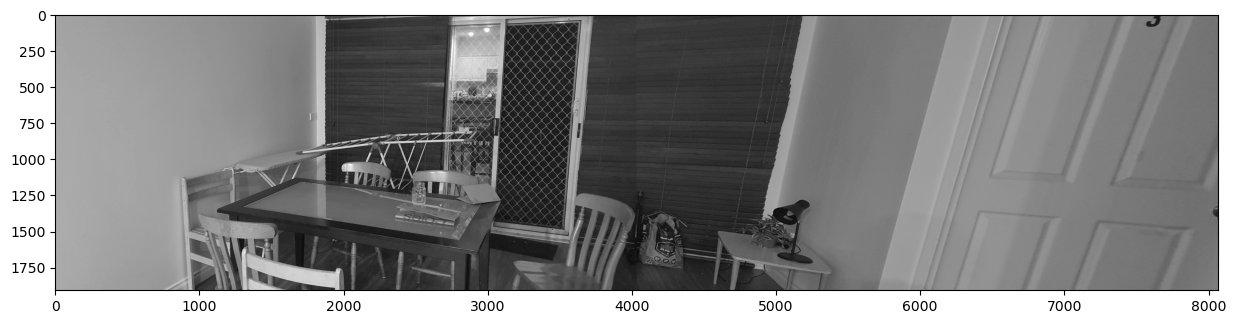

In [492]:
# Show results here

plt.figure(figsize=(15,5))
plt.imshow(wider_img,'gray')
#plt.imshow(SCALED_wider_img,'gray')

#### Demonstrate your understanding by answering the question below:
#### How did you adapt your previous code to solve this problem?  
#### I first found the Homography matrix using the code used in the Week 4 workshop
#### After that I used the stitch_two_imgs fucntion from earlier, using my images and the calcualted homography matrix
#### I didn't crop the image as before, since there wans't that much overlap between the images this time, and the right image got so stretched that it covered the entire right side
#### I used the same gaussian blur as before using the cv2 gaussian blur function
#### with scaling brightness I used a scale_birghtness function, which does the same this as the previous part, where it takes the featers coordiantes, X1 and X2, and comapres the brightness values between the two images. However it didn't seem to work like it did in the previous part, since some features are brighter in the first image, while other features are dimmer.
#### As a result of that, I tried another method where I comapre the brightness of pixels along the seam, since they more or less should represent the same things, and got my scale value that way. and it seems to work a lot better.
